# ISB-workshop 2021

This script formulates and solves a trajectory optimization problem underlying a predictive simulation of walking with a planar five-link biped model. A direct collocation method with a backward Euler integration scheme is employed to formulate a nonlinear programming problem (NLP) from the continuous optimization problem. The formulation is deeply inspired from the five-link biped example described in: "Kelly, An Introduction to Trajectory Optimization: How to Do Your Own Direct Collocation (2017), SIAM REVIEW. DOI. 10.1137/16M1062569".
    
Author: Tom Van Wouwe
Contributor: Antoine Falisse


## Problem setup



### Import

Run the code below to import the required modules.

In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from getDynamicConstraintErrors import getDynamicConstraintErrors
from getHeelStrikeError import getHeelStrikeError
from eulerIntegrator import eulerIntegrator
from getJointKinematics import getJointPositions
from getJointKinematics import getJointVelocities
from getJointKinematics import getRelativeJointPositions
from getJointKinematics import getRelativeJointVelocities
from generateAnimation import generateAnimation

### Gait style

Set the variable selected_gait to one of the following pre-defined gait style:
  - nominal
  - no_ankle_torque
  - no_knee_torque
  - no_hip_torque
  - only_ankle_torque
  - only_knee_torque
  - only_hip_torque
  - crouch_gait
  - swing_foot_circles_around_stance_foot
  - on_the_moon

In [2]:
selected_gait = 'nominal'

### Model description

Set the physical parameters for the five-link biped model. As is, the parameters are those from the original model, as described in the following table (Table 4 from appendix E.2, p897 of Kelly 2017):

Symbol    Value         Name
m1, m5    3.2 kg        mass of the tibia (lower leg)
m2, m4    6.8 kg        mass of the femur (upper leg)
m3        20 kg         mass of the torso
I1, I5    0.93 kg-m2    rotational inertia of tibia about center of mass
I2, I4    1.08 kg-m2    rotational inertia of femur about center of mass
I3        2.22 kg-m2    rotational inertia of torso about center of mass
l1, l5    0.4 m         length of tibia
l2, l4    0.4 m         length of femur
l3        0.625 m       length of torso
d1, d5    0.128 m       distance from tibia center of mass to knee
d2, d4    0.163 m       distance from femur center of mass to hip
d3        0.2 m         distance from torso center of mass to hip

You can also adjust the variable g, which describes gravity.

In [3]:
m1 = 3.2
m5 = 3.2
m2 = 6.8
m4 = 6.8
m3 = 20
I1 = 0.93
I5 = 0.93
I2 = 1.08
I4 = 1.08
I3 = 2.22
l1 = 0.4
l5 = 0.4
l2 = 0.4
l4 = 0.4
l3 = 0.625
d1 = 0.128
d5 = 0.128
d2 = 0.163 
d4 = 0.163
d3 = 0.2
lc1 = l1 - 0.128
lc5 = lc1
lc2 = l2-0.163
lc4 = lc2
lc3 = 0.2

if selected_gait == 'on_the_moon':
    g = 1.62
else:
    g = 9.81

### Model dynamics

We created the function getDynamicConstraintErrors that will return the dynamic constraint errors when called during the optimization. This function is still valid if you change the mass, intertia, or length of the segments. but will no longer be valid for another model (eg, a model with more segments).

In [4]:
f_getDynamicConstraintErrors = getDynamicConstraintErrors(
    m1, m2, m3, m4, m5,
    I1, I2, I3, I4, I5,
    d1, d2, d3, d4, d5,
    l1, l2, l3, l4, l5,
    g)

### Trajectory optimization problem

We first set the stride time, mesh size, number of mesh intervals, and stride length.

In [5]:
T = 0.8                         # Stride time (s).
dt = 0.01                       # Mesh size.
N = int(T/dt)                   # Number of mesh intervals.
time = np.linspace(0., T, N+1)  # Discretized time vector.
strideLength = 0.5              # Stride length (m).

We formulate the NLP using Opti Stack, which is a collection of CasADi helper classes that provides a close correspondence between mathematical NLP notation and computer code. More info here: https://web.casadi.org/docs/#document-opti

We first create the optimization variables (joint positions, velocities, accelerations, and torques), and set bounds and initial guess for some of them.

In [6]:
# Create opti instance.
opti = ca.Opti()

# Create optimization variables.
# Joint positions.
q1 = opti.variable(1,N+1)
q2 = opti.variable(1,N+1) 
q3 = opti.variable(1,N+1)
q4 = opti.variable(1,N+1)  
q5 = opti.variable(1,N+1)
# Joint velocities.
dq1 = opti.variable(1,N+1)
dq2 = opti.variable(1,N+1)  
dq3 = opti.variable(1,N+1)
dq4 = opti.variable(1,N+1)  
dq5 = opti.variable(1,N+1)
# Joint accelerations.
ddq1 = opti.variable(1,N)
ddq2 = opti.variable(1,N)   
ddq3 = opti.variable(1,N)
ddq4 = opti.variable(1,N)
ddq5 = opti.variable(1,N)
# Joint torques.
T1 = opti.variable(1,N)
T2 = opti.variable(1,N)  
T3 = opti.variable(1,N)
T4 = opti.variable(1,N)   
T5 = opti.variable(1,N)

# Set bounds on joint positions.
opti.subject_to(opti.bounded(-np.pi/2, q1, np.pi/2))
opti.subject_to(opti.bounded(-np.pi/2, q2, np.pi/2))
opti.subject_to(opti.bounded(-np.pi/3, q3, np.pi/3))
opti.subject_to(opti.bounded(-np.pi/2, q4, np.pi/2))
opti.subject_to(opti.bounded(-np.pi/2, q5, np.pi/2))
# Set physiological knee joint limits (no hyperflexion).
opti.subject_to(opti.bounded(-np.pi, q1 - q2, 0))
opti.subject_to(opti.bounded(-np.pi, q5 - q4, 0))

# Set naive initial guess for the joint positions
# (linearly spaced vector between lower and upper bounds).
q1_init = -np.pi/8
q1_final = -np.pi/6   
q2_init = np.pi/6
q2_final = -np.pi/8
q3_init = -np.pi/6
q3_final = 0
q4_init = -np.pi/8
q4_final = np.pi/6
q5_init = -np.pi/6
q5_final = -np.pi/8   

q1guess = np.linspace(q1_init, q1_final, N+1)
q2guess = np.linspace(q2_init, q2_final, N+1)
q3guess = np.linspace(q3_init, q3_final, N+1)
q4guess = np.linspace(q4_init, q4_final, N+1)
q5guess = np.linspace(q5_init, q5_final, N+1)

opti.set_initial(q1, q1guess)
opti.set_initial(q2, q2guess)
opti.set_initial(q3, q3guess)
opti.set_initial(q4, q4guess)
opti.set_initial(q5, q5guess)


We impose a periodic gait pattern.

"...we will assume that the model transitions directly from single stance on one foot to single stance on the other: as soon as the leading foot strikes the ground, the trailing foot leaves the ground. This transition is known as a heel-strike map...There are two parts to the heel-strike map. The first is an impulsive collision, which changes the joint velocities throughout the model, but does not affect the configuration (angles). The second part of the map swaps the swing and stance legs. The leg swap is done to enforce a symmetry in the solution: we want the step taken by the left leg to be identical to that for the right, and for both to be periodic." (Appendix F3, Heel-Strike Dynamics, p899, Kelly 2017). The angular momentum is conserved around the collision point for all joints giving 5 constraint equations.

In [7]:
# Impose periodic gait.
q1_min = q1[:,-1]     
q2_min = q2[:,-1] 
q3_min = q3[:,-1]     
q4_min = q4[:,-1]     
q5_min = q5[:,-1]
q1_plus = q1[:,0]      
q2_plus = q2[:,0] 
q3_plus = q3[:,0]      
q4_plus = q4[:,0]      
q5_plus = q5[:,0]
dq1_min = dq1[:,-1]   
dq2_min = dq2[:,-1] 
dq3_min = dq3[:,-1]   
dq4_min = dq4[:,-1]   
dq5_min = dq5[:,-1]
dq1_plus = dq1[:,0]    
dq2_plus = dq2[:,0] 
dq3_plus = dq3[:,0]    
dq4_plus = dq4[:,0]    
dq5_plus = dq5[:,0]
heelStrike_error = getHeelStrikeError(
    I1,I2,I3,I4,I5,
    dq1_min,dq2_min,dq3_min,dq4_min,dq5_min,
    dq1_plus,dq2_plus,dq3_plus,dq4_plus,dq5_plus,
    l1,l2,l4,l5,
    lc1,lc2,lc3,lc4,lc5,
    m1,m2,m3,m4,m5,
    q1_min,q2_min,q3_min,q4_min,q5_min,
    q1_plus,q2_plus,q3_plus,q4_plus,q5_plus)
opti.subject_to(ca.vertcat(*heelStrike_error) == 0)

We then loop over the mesh points, add contributions to the cost function, and set dynamic and path constraints.

In [8]:
# Initialize the cost function (J).
J = 0

# Loop over mesh points.
for k in range(N):
    # States at mesh point k.
    q1k = q1[:,k]     
    q2k = q2[:,k]     
    q3k = q3[:,k]
    q4k = q4[:,k]     
    q5k = q5[:,k]
    
    dq1k = dq1[:,k]   
    dq2k = dq2[:,k]   
    dq3k = dq3[:,k]
    dq4k = dq4[:,k]   
    dq5k = dq5[:,k]
    
    # Control/lifted state variables for mesh k.
    ddq1k = ddq1[:,k] 
    ddq2k = ddq2[:,k] 
    ddq3k = ddq3[:,k] 
    ddq4k = ddq4[:,k] 
    ddq5k = ddq5[:,k]
    
    T1k = T1[:,k]     
    T2k = T2[:,k]     
    T3k = T3[:,k]     
    T4k = T4[:,k]     
    T5k = T5[:,k]
    
    # States at mesh point k+1.
    q1k_plus = q1[:,k+1]     
    q2k_plus = q2[:,k+1]     
    q3k_plus = q3[:,k+1]     
    q4k_plus = q4[:,k+1]     
    q5k_plus = q5[:,k+1]
    
    dq1k_plus = dq1[:,k+1]   
    dq2k_plus = dq2[:,k+1]   
    dq3k_plus = dq3[:,k+1]   
    dq4k_plus = dq4[:,k+1]   
    dq5k_plus = dq5[:,k+1]
       
    # Stack states at mesh points k and k+1.    
    Xk = ca.vertcat(q1k, q2k, q3k, q4k, q5k,   
          dq1k, dq2k, dq3k, dq4k, dq5k)
    Xk_plus = ca.vertcat(q1k_plus, q2k_plus, q3k_plus, q4k_plus, q5k_plus,
               dq1k_plus, dq2k_plus, dq3k_plus, dq4k_plus, dq5k_plus)
    
    # Stack state derivatives.
    Uk = ca.vertcat(dq1k_plus, dq2k_plus, dq3k_plus, dq4k_plus, dq5k_plus, 
          ddq1k, ddq2k, ddq3k, ddq4k, ddq5k)
    
    # Integration.
    opti.subject_to(eulerIntegrator(Xk, Xk_plus, Uk, dt) == 0)
       
    # Dynamic constraint errors.
    dynamicConstraintErrors = f_getDynamicConstraintErrors(
        T1k,T2k,T3k,T4k,T5k,
        ddq1k,ddq2k,ddq3k,ddq4k,ddq5k,
        dq1k_plus,dq2k_plus,dq3k_plus,dq4k_plus,dq5k_plus,
        q1k_plus,q2k_plus,q3k_plus,q4k_plus,q5k_plus)
    opti.subject_to(ca.vertcat(*dynamicConstraintErrors) == 0)
    
    # Cost function contributions.
    # Minimize the sum of the squared joint torques.
    J = J + (T1k**2 + T2k**2 + T3k**2 + T4k**2 + T5k**2)*dt
    # Penalize (with low weight) joint accelerations for regularization.
    J = J + 1e-1*(ddq1k**2 + ddq2k**2 + ddq3k**2 + ddq4k**2 + ddq5k**2)*dt
    
    # Impose the swing foot to be off the ground.
    # Joint locations in x-y plane.
    jointPositions = getJointPositions(l1,l2,l3,l4,l5,q1k,q2k,q3k,q4k,q5k)
    opti.subject_to(jointPositions[9] > -1e-4)
    
    # Walking style.
    if selected_gait == 'no_ankle_torque':
        opti.subject_to(T1k  == 0.0)         
    elif selected_gait == 'no_knee_torque':
        opti.subject_to(T2k  == 0.0)  
    elif selected_gait ==  'no_hip_torque':
        opti.subject_to(T3k  == 0.0)
        opti.subject_to(T4k  == 0.0)     
    elif selected_gait ==  'only_ankle_torque':
        opti.subject_to(T2k  == 0.0)
        opti.subject_to(T3k  == 0.0)
        opti.subject_to(T4k  == 0.0)
        opti.subject_to(T5k  == 0.0)        
    elif selected_gait ==  'only_knee_torque':
        opti.subject_to(T1k  == 0.0)
        opti.subject_to(T3k  == 0.0)
        opti.subject_to(T4k  == 0.0)
    elif selected_gait ==  'only_hip_torque':
        opti.subject_to(T1k  == 0.0)
        opti.subject_to(T2k  == 0.0)
        opti.subject_to(T5k  == 0.0)    
    elif selected_gait ==  'crouch_gait':
        opti.subject_to(jointPositions(4)<0.6) # Pelvis below 0.6 m            
    elif selected_gait ==  'swing_foot_circles_around_stance_foot':
        opti.subject_to(            
            jointPositions[8]**2 + jointPositions[9]**2 > 0.45**2)

We impose the pre-defined gait speed.

"...what we have chosen here is to prescribe the duration of a single step (T) and then put an equality constraint on the stride length..."

We also impose the simulation to start at 'toe-off' and end at 'heel-strike', by imposing the swing foot to have a positive y-velocity at 'toe-off' and a negative y-velocity at 'heel strike'.

In [9]:
# Impose gait speed.
jointPositionsEnd = getJointPositions(l1,l2,l3,l4,l5,
    q1[:,-1],q2[:,-1],q3[:,-1],q4[:,-1],q5[:,-1])
# jointPositionsEnd(9:10,:) is the swing foot position at the end.
opti.subject_to(jointPositionsEnd[8] == strideLength)
opti.subject_to(jointPositionsEnd[9] == 0)

# Impose to start at 'toe-off' and end at 'heel-strike'.
JointVelocitiesInit = getJointVelocities(
    dq1 [:,0],dq2 [:,0],dq3 [:,0],dq4 [:,0],dq5 [:,0],
    l1,l2,l3,l4,l5,q1 [:,0],
    q2 [:,0],q3 [:,0],q4 [:,0],q5 [:,0])
JointVelocitiesEnd = getJointVelocities(
    dq1[:,-1],dq2[:,-1],dq3[:,-1],dq4[:,-1],dq5[:,-1],
    l1,l2,l3,l4,l5,
    q1[:,-1],q2[:,-1],q3[:,-1],q4[:,-1],q5[:,-1])
opti.subject_to(JointVelocitiesInit[9] > 0)
opti.subject_to(JointVelocitiesEnd[9] < 0)

We finally set the solver and solve the problem. The problem with the nominal gait style should converge in 24 iterations in only a couple of seconds.

In [10]:
# Define cost function.
opti.minimize(J)

# Create an NLP solver.
opti.solver('ipopt')

# Solve the NLP.
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8253
Number of nonzeros in inequality constraint Jacobian.:     1065
Number of nonzeros in Lagrangian Hessian.............:     5638

Total number of variables............................:     1610
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

## Results analysis

We first extract the optimal states and controls.

In [11]:
# %% Extract the optimal states and controls.
# Optimal joint positions.
q1_opt = sol.value(q1)
q2_opt = sol.value(q2)
q3_opt = sol.value(q3)
q4_opt = sol.value(q4)
q5_opt = sol.value(q5)
# Optimal joint velocities.
dq1_opt = sol.value(dq1)
dq2_opt = sol.value(dq2)
dq3_opt = sol.value(dq3)
dq4_opt = sol.value(dq4)
dq5_opt = sol.value(dq5)
# Optimal joint accelerations.
ddq1_opt = sol.value(ddq1)
ddq2_opt = sol.value(ddq2)
ddq3_opt = sol.value(ddq3)
ddq4_opt = sol.value(ddq4)
ddq5_opt = sol.value(ddq5)
# Optimal joint torques.
T1_opt = sol.value(T1)
T2_opt = sol.value(T2)
T3_opt = sol.value(T3)
T4_opt = sol.value(T4)
T5_opt = sol.value(T5)

We then plot the optimal joint torques, segment positions and velocities.

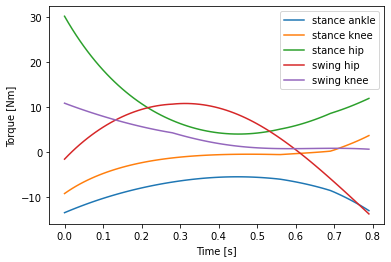

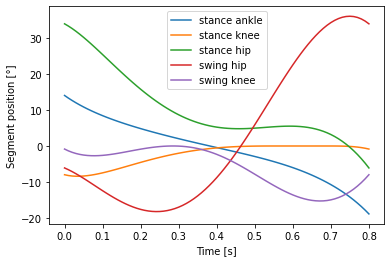

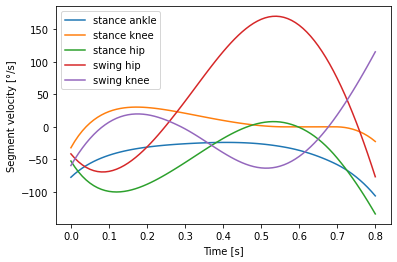

The joint torque term contributes for 95.13% of the optimal cost value      


In [12]:
# %% Plots.
# Joint torques.
fig = plt.figure()
ax = plt.gca()
lineObjects = ax.plot(time[:-1],T1_opt,
                      time[:-1],T2_opt,
                      time[:-1],T3_opt,
                      time[:-1],T4_opt,
                      time[:-1],T5_opt)
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend(iter(lineObjects), ('stance ankle','stance knee','stance hip',
                               'swing hip','swing knee'))
plt.show()

# Relative joint positions.
relJointPos = getRelativeJointPositions(
    q1_opt,q2_opt,q3_opt,q4_opt,q5_opt)
fig = plt.figure()
ax = plt.gca()
lineObjects = ax.plot(time,180/np.pi*relJointPos[0],
                      time,180/np.pi*relJointPos[1],
                      time,180/np.pi*relJointPos[2],
                      time,180/np.pi*relJointPos[3],
                      time,180/np.pi*relJointPos[4])
plt.xlabel('Time [s]')
plt.ylabel('Segment position [°]')
plt.legend(iter(lineObjects), ('stance ankle','stance knee','stance hip',
                               'swing hip','swing knee'))
plt.show()

# Relative joint velocities.
relJointVel = getRelativeJointVelocities(
    dq1_opt,dq2_opt,dq3_opt,dq4_opt,dq5_opt)
fig = plt.figure()
ax = plt.gca()
lineObjects = ax.plot(time,180/np.pi*relJointVel[0],
                      time,180/np.pi*relJointVel[1],
                      time,180/np.pi*relJointVel[2],
                      time,180/np.pi*relJointVel[3],
                      time,180/np.pi*relJointVel[4])
plt.xlabel('Time [s]')
plt.ylabel('Segment velocity [°/s]')
plt.legend(iter(lineObjects), ('stance ankle','stance knee','stance hip',
                               'swing hip','swing knee'))
plt.show()

# %% Analysis of the cost function.
J_torque = (ca.sumsqr(T1_opt).full() + ca.sumsqr(T2_opt).full() + 
            ca.sumsqr(T3_opt).full() + ca.sumsqr(T4_opt).full() + 
            ca.sumsqr(T5_opt).full())*dt
J_ddq = 0.1*(ca.sumsqr(ddq1_opt).full() + ca.sumsqr(ddq2_opt).full() + 
             ca.sumsqr(ddq3_opt).full() + ca.sumsqr(ddq4_opt).full() + 
             ca.sumsqr(ddq5_opt).full())*dt
J_tot = J_torque + J_ddq
J_torque_cont = np.round(J_torque / J_tot * 100, 2)[0][0]

print('The joint torque term contributes for {}% of the optimal cost value\
      '.format(J_torque_cont))

Finally, we can visualize the gait pattern.

For this to work, you might need to install FFmpeg in the first place: https://www.ffmpeg.org/.

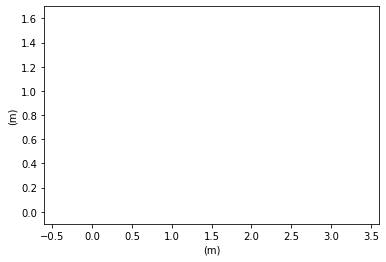

In [13]:
# %% Generate an animation.
jointPositions_opt = getJointPositions(
    l1,l2,l3,l4,l5,
    q1_opt,q2_opt,q3_opt,q4_opt,q5_opt)
from IPython.display import HTML
animation = generateAnimation(jointPositions_opt, dt, strideLength)
plt.close()
HTML(animation.to_html5_video())

Version 1.0

Creator: Tom Van Wouwe | Contributor: Antoine Falisse  
Last Updated on Jun. 26, 2021

This notebook is made available under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0).